In [43]:
import numpy as np
import pandas as pd
import random

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn import metrics


In [46]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))
    fpr, tpr, thresholds = metrics.roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    if returnPreds==True:
        return preds

In [25]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)- np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return (loss)

In [26]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector",
               hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

In [5]:
main_data = pd.read_excel(f"E:\gitlab\machine-learning\dataset\Indosat_v4.xls",index=False)
main_data.head()

,status,tenure,subscriber_type,area,handset_type,vol_of_usg,data_rev,voice_duration,invoice_amount,data_usage_in_mb,usage_in_a_month,apps_travel,apps_ecommerce,apps_finance,apps_socialnet,apps_transportation,apps_video,age_catg,gender
0,3,5,0,4,5,63704038012,29303.0,0,30000,0,400,0,0,0,0,0,0,50,1
1,2,0,0,4,5,30230593292,249076.0,0,40000,0,300,0,0,0,0,0,0,50,1
2,3,3,0,6,5,9812721395,50000.0,0,50000,376704,100,1,1,1,1,0,1,50,1
3,1,2,1,4,4,74995444756,146982.0,0,60000,0,100,0,0,0,0,0,0,70,0
4,3,3,0,5,5,23673284518,80000.0,0,70000,265588,100,1,1,1,1,0,1,20,0


In [6]:
main_data.shape

(1000, 19)

# PCA Components Equal Number of Original Dimensions

<IPython.core.display.Javascript object>


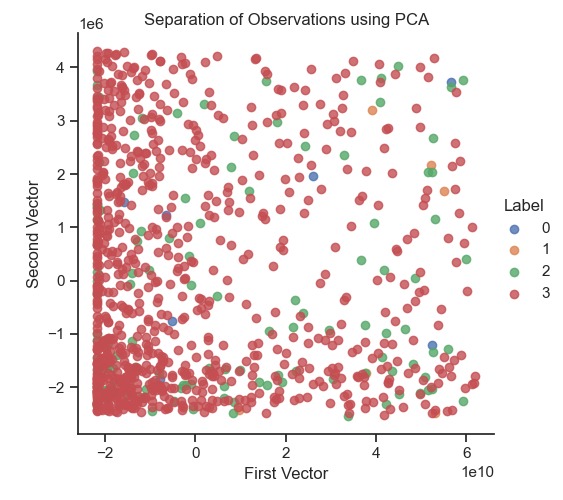

In [78]:
# 30 principal components
n_components = 10
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(main_data)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=main_data.index)
X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=main_data.index)
scatterPlot(X_train_PCA, main_data["status"], "PCA")

<IPython.core.display.Javascript object>


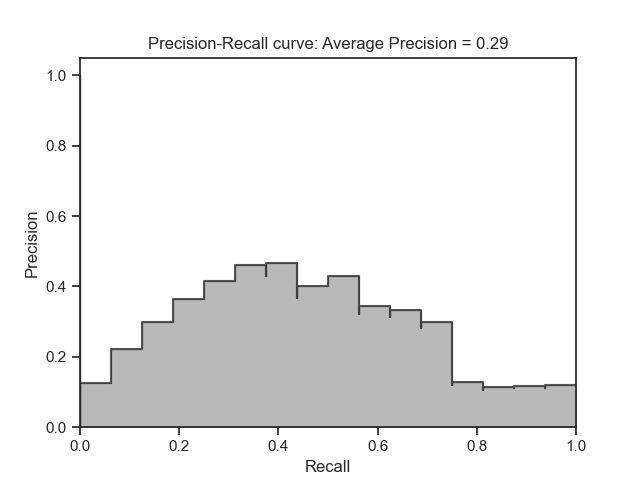

<IPython.core.display.Javascript object>


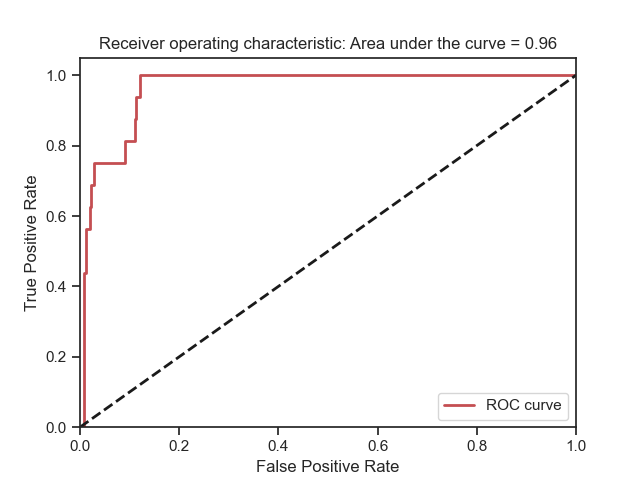

In [79]:
anomalyScoresPCA = anomalyScores(main_data, X_train_PCA_inverse)
preds = plotResults(main_data["subscriber_type"], anomalyScoresPCA, True)

In [81]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True) 
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop.anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop.anomalyScore[predsTop.trueLabel==1].count()/main_data["subscriber_type"].sum(),2))

Precision:  0.05
Recall:  1.0


# Search for the Optimal Number of Principal Components